In [2]:
# TÍTULO: Ingeniería de Datos - Detector de Placas
# OBJETIVO: Analizar distribución original, limpiar duplicados, normalizar clases y generar split propio.

import os
import glob
import shutil
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
import imagehash
from PIL import Image
from sklearn.model_selection import train_test_split

# --- RUTAS RELATIVAS (Subimos 2 niveles desde notebooks/02_placas) ---
# Origen: Donde descargó el setup (Staging)
SOURCE_PATH = '../../data/processed/02_placas_original'

# Destino: Donde entrenará YOLO (Producción)
DEST_PATH = '../../datasets/02_placas'

# Semilla para reproducibilidad científica
RANDOM_SEED = 42

print("✅ Entorno configurado.")

✅ Entorno configurado.


In [3]:
def inventory_dataset_preserving_split(root_path):
    data_pairs = []
    
    # 1. Búsqueda Recursiva de Imágenes
    # Soportamos múltiples extensiones
    extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG']
    all_images = []
    for ext in extensions:
        all_images.extend(glob.glob(os.path.join(root_path, '**', ext), recursive=True))
    
    print(f"🔍 Escaneando {len(all_images)} imágenes y detectando su origen...")
    
    for img_path in tqdm(all_images):
        dirname = os.path.dirname(img_path)
        basename = os.path.splitext(os.path.basename(img_path))[0]
        full_path_str = os.path.abspath(img_path)
        
        # --- A. DETECCIÓN DE SPLIT ORIGINAL ---
        # Analizamos la ruta para ver de dónde viene (heurística)
        path_parts = full_path_str.lower().replace('\\', '/').split('/')
        
        original_split = 'unknown'
        if 'train' in path_parts:
            original_split = 'train'
        elif 'test' in path_parts:
            original_split = 'test'
        elif 'valid' in path_parts or 'val' in path_parts:
            original_split = 'val'
            
        # --- B. BÚSQUEDA DE ETIQUETA ---
        # Buscamos el txt en lugares comunes
        possible_labels = [
            os.path.join(dirname, basename + '.txt'),                     # Misma carpeta
            os.path.join(dirname.replace('images', 'labels'), basename + '.txt'), # Carpeta labels paralela
            os.path.join(dirname, '..', 'labels', basename + '.txt'),     # Un nivel arriba
             # Caso específico de algunos datasets anidados
            os.path.join(os.path.dirname(dirname), 'labels', basename + '.txt')
        ]
        
        found_label = None
        for lbl in possible_labels:
            if os.path.exists(lbl) and os.path.getsize(lbl) > 0:
                found_label = os.path.abspath(lbl)
                break
        
        if found_label:
            data_pairs.append({
                'id': basename,
                'image_path': full_path_str,
                'label_path': found_label,
                'original_split': original_split
            })
    
    return pd.DataFrame(data_pairs)

# Ejecutar Inventario
df_placas = inventory_dataset_preserving_split(SOURCE_PATH)
print(f"✅ Inventario completado: {len(df_placas)} pares imagen-etiqueta válidos.")
df_placas.head()

🔍 Escaneando 26929 imágenes y detectando su origen...


  0%|          | 0/26929 [00:00<?, ?it/s]

✅ Inventario completado: 26911 pares imagen-etiqueta válidos.


,id,image_path,label_path,original_split
0,4cacae57d485dd49,/home/roberto/proyecto/data/processed/02_placa...,/home/roberto/proyecto/data/processed/02_placa...,val
1,7b7cb1823200d38b,/home/roberto/proyecto/data/processed/02_placa...,/home/roberto/proyecto/data/processed/02_placa...,val
2,77f0a0e685f22abe,/home/roberto/proyecto/data/processed/02_placa...,/home/roberto/proyecto/data/processed/02_placa...,val
3,76d9a3ecb26a5706,/home/roberto/proyecto/data/processed/02_placa...,/home/roberto/proyecto/data/processed/02_placa...,val
4,fd9d11402a08127f,/home/roberto/proyecto/data/processed/02_placa...,/home/roberto/proyecto/data/processed/02_placa...,val


📊 Estadística de Distribución Original:
   - Train: 25452 (94.58%)
   - Val: 1073 (3.99%)
   - Test: 386 (1.43%)


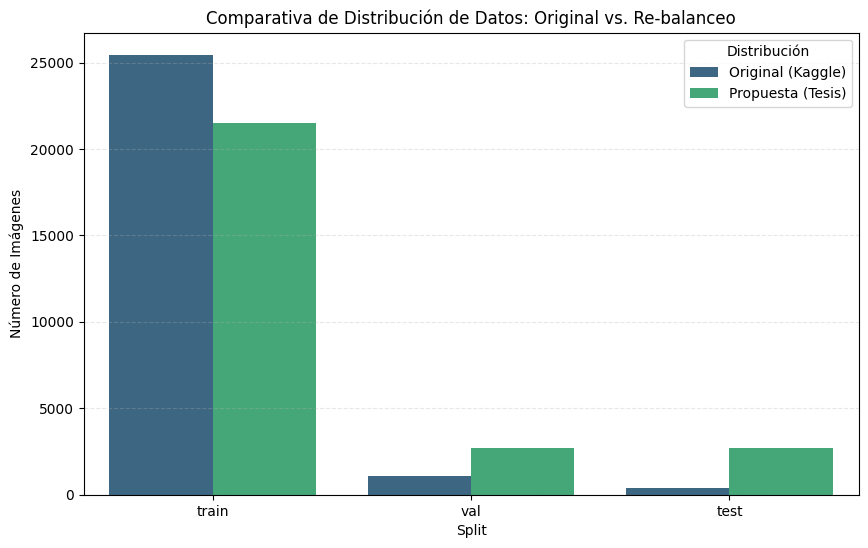

In [4]:
# --- GRÁFICA: DISTRIBUCIÓN ORIGINAL VS PROPUESTA ---

# 1. Datos Originales (Lo que bajamos de Kaggle)
original_counts = df_placas['original_split'].value_counts()
order = ['train', 'val', 'test']
original_vals = [original_counts.get(k, 0) for k in order]

# 2. Datos Propuestos (Tu split ideal 80/10/10)
total_imgs = len(df_placas)
ideal_vals = [int(total_imgs*0.8), int(total_imgs*0.1), int(total_imgs*0.1)]

# DataFrame para Seaborn
df_viz = pd.DataFrame({
    'Split': order * 2,
    'Cantidad': original_vals + ideal_vals,
    'Distribución': ['Original (Kaggle)']*3 + ['Propuesta (Tesis)']*3
})

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(data=df_viz, x='Split', y='Cantidad', hue='Distribución', palette='viridis')
plt.title('Comparativa de Distribución de Datos: Original vs. Re-balanceo')
plt.ylabel('Número de Imágenes')
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Mostrar datos en consola
print("📊 Estadística de Distribución Original:")
for split in order:
    count = original_counts.get(split, 0)
    pct = (count / total_imgs) * 100 if total_imgs > 0 else 0
    print(f"   - {split.capitalize()}: {count} ({pct:.2f}%)")

plt.show()

👁️ Auditando 5 muestras aleatorias...


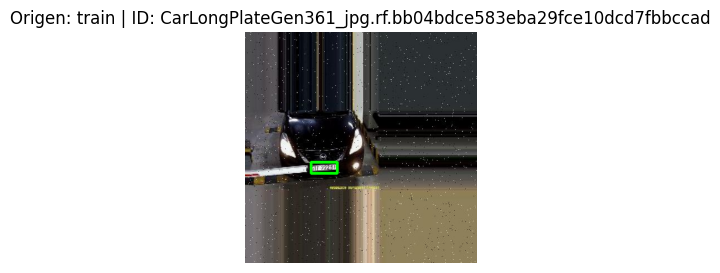

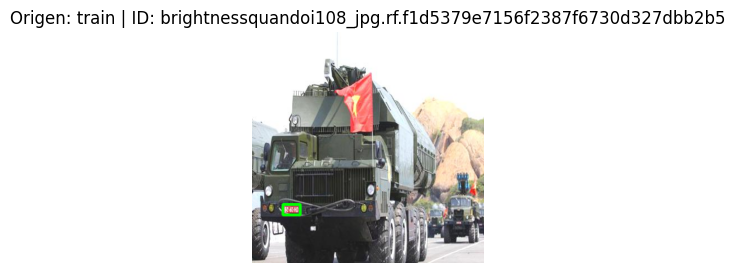

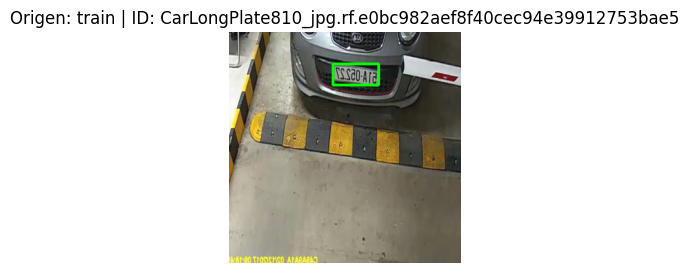

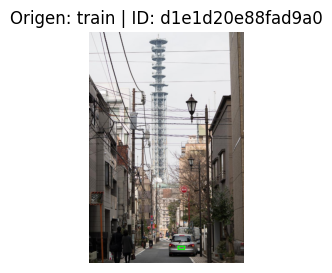

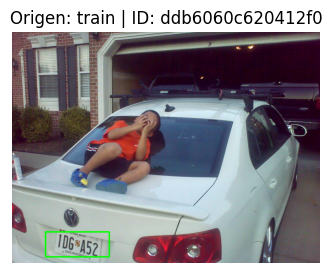

In [7]:
def audit_labels(df, num_samples=5):
    samples = df.sample(num_samples, random_state=RANDOM_SEED)
    print(f"👁️ Auditando {num_samples} muestras aleatorias...")
    
    for _, row in samples.iterrows():
        img = cv2.imread(row['image_path'])
        if img is None: continue
        h_img, w_img, _ = img.shape
        
        # Leer label original
        with open(row['label_path'], 'r') as f:
            lines = f.readlines()
            
        for line in lines:
            parts = list(map(float, line.strip().split()))
            if len(parts) >= 5:
                # Dibujamos lo que dice el txt
                xc, yc, w, h = parts[1], parts[2], parts[3], parts[4]
                x1 = int((xc - w/2) * w_img)
                y1 = int((yc - h/2) * h_img)
                x2 = int((xc + w/2) * w_img)
                y2 = int((yc + h/2) * h_img)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
        
        plt.figure(figsize=(6,3))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Origen: {row['original_split']} | ID: {row['id']}")
        plt.axis('off')
        plt.show()

audit_labels(df_placas)

🕵️ Generando huellas digitales (PHash size=8)...


  0%|          | 0/26911 [00:00<?, ?it/s]


📊 Resumen de Duplicidad:
   - Total procesado: 26911
   - Duplicados encontrados: 288

👁️ Inspección Visual (Mostrando 5 de 288 casos):


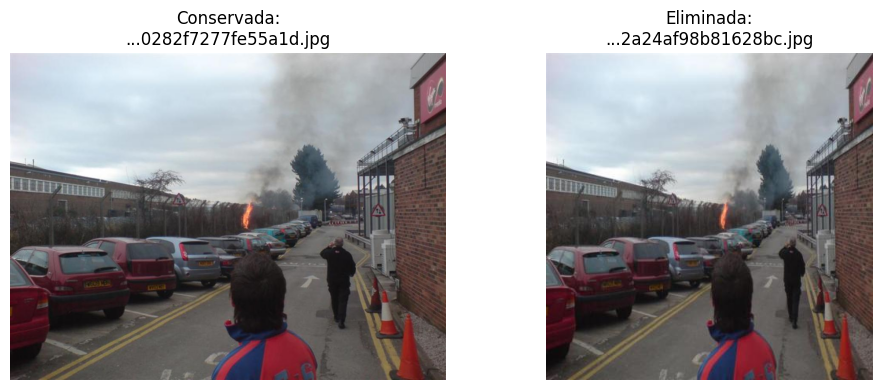

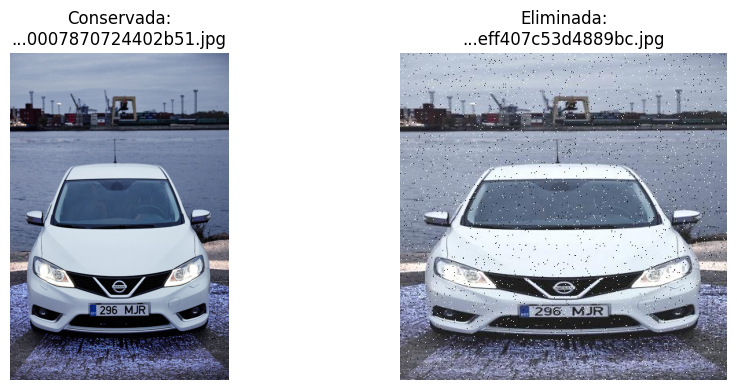

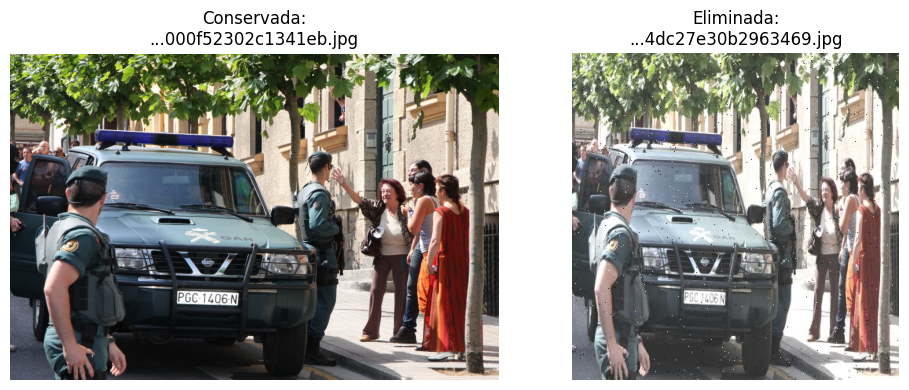

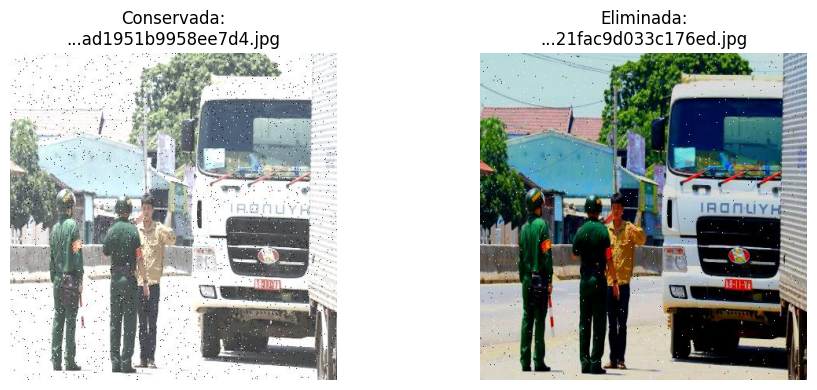

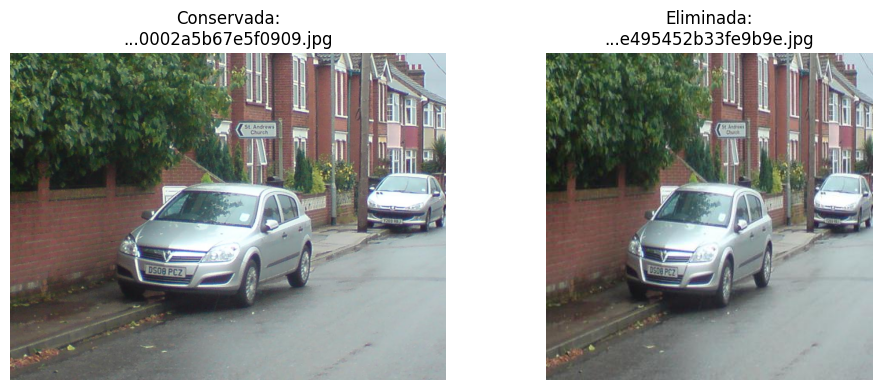

📝 Reporte detallado guardado en: /home/roberto/proyecto/data/processed/02_placas_reporte_duplicados.csv
   (Puedes abrir este archivo en Excel para auditar qué se eliminó)

✨ Dataset Limpio Final: 26623 imágenes únicas.


In [20]:
# --- CELDA 5: Detección, Visualización y Reporte de Duplicados ---

def analyze_duplicates(df, hash_size=16):
    """
    Calcula hashes perceptuales (PHash) y devuelve:
    1. Lista de índices a eliminar.
    2. Lista de tuplas (ruta_original, ruta_duplicada) para visualizar.
    """
    print(f"🕵️ Generando huellas digitales (PHash size={hash_size})...")
    
    hashes = {}          # {hash: ruta_imagen}
    drop_indices = []    # Índices del DataFrame a borrar
    duplicate_pairs = [] # (ruta_kept, ruta_dropped)
    
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        try:
            with Image.open(row['image_path']) as img:
                h = str(imagehash.phash(img, hash_size=hash_size))
                
                if h in hashes:
                    # ¡Colisión! Es un duplicado
                    original_path = hashes[h]
                    current_path = row['image_path']
                    
                    duplicate_pairs.append((original_path, current_path))
                    drop_indices.append(idx)
                else:
                    hashes[h] = row['image_path']
                    
        except Exception as e:
            # Si la imagen está corrupta, la marcamos para borrar también
            drop_indices.append(idx)
            
    return drop_indices, duplicate_pairs

def visualize_duplicates(pairs, limit=5):
    if not pairs:
        print("✅ No se encontraron duplicados visuales.")
        return

    print(f"\n👁️ Inspección Visual (Mostrando {min(len(pairs), limit)} de {len(pairs)} casos):")
    
    for i, (orig, dupe) in enumerate(pairs[:limit]):
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        # Imagen Original
        img1 = Image.open(orig)
        axes[0].imshow(img1, cmap='gray')
        axes[0].set_title(f"Conservada:\n...{os.path.basename(orig)[-20:]}")
        axes[0].axis('off')
        
        # Imagen Duplicada
        img2 = Image.open(dupe)
        axes[1].imshow(img2, cmap='gray')
        axes[1].set_title(f"Eliminada:\n...{os.path.basename(dupe)[-20:]}")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

# --- EJECUCIÓN ---

# 1. Análisis
drop_indices, dupe_pairs = analyze_duplicates(df_placas, hash_size=8)

# 2. Reporte en Consola
print(f"\n📊 Resumen de Duplicidad:")
print(f"   - Total procesado: {len(df_placas)}")
print(f"   - Duplicados encontrados: {len(drop_indices)}")

# 3. Visualización
visualize_duplicates(dupe_pairs, limit=5)

# 4. GUARDAR REPORTE (Excel/CSV) <--- AQUÍ ESTÁ LO QUE PEDISTE
if dupe_pairs:
    # Crear DataFrame con las parejas
    report_df = pd.DataFrame(dupe_pairs, columns=['Ruta_Original_Conservada', 'Ruta_Duplicada_Eliminada'])
    
    # Ruta de guardado (en data/processed para mantener el orden)
    report_path = '../../data/processed/02_placas_reporte_duplicados.csv'
    
    # Guardar
    report_df.to_csv(report_path, index=False)
    print(f"📝 Reporte detallado guardado en: {os.path.abspath(report_path)}")
    print("   (Puedes abrir este archivo en Excel para auditar qué se eliminó)")

# 5. Limpieza del DataFrame principal
df_clean = df_placas.drop(drop_indices).reset_index(drop=True)
print(f"\n✨ Dataset Limpio Final: {len(df_clean)} imágenes únicas.")

In [10]:
# CONFIGURACIÓN DE PROCESAMIENTO
FORCE_CLASS_ID = 0        # La placa siempre será clase 0
APPLY_PADDING = False     # Cambiar a True si se requiere margen
PADDING_PCT = 0.10

# 1. Generar Split Propio (80/10/10)
train_df, temp_df = train_test_split(df_clean, test_size=0.2, random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=RANDOM_SEED)

def expand_box(xc, yc, w, h, padding):
    new_w = min(1.0, w * (1 + padding))
    new_h = min(1.0, h * (1 + padding))
    return xc, yc, new_w, new_h

def process_and_save(df, split_name):
    img_dest = os.path.join(DEST_PATH, split_name, 'images')
    lbl_dest = os.path.join(DEST_PATH, split_name, 'labels')
    os.makedirs(img_dest, exist_ok=True)
    os.makedirs(lbl_dest, exist_ok=True)
    
    print(f"💾 Procesando {split_name} ({len(df)} archivos)...")
    
    for _, row in tqdm(df.iterrows()):
        # A. Copiar Imagen
        # Preservamos extensión original
        ext = os.path.splitext(row['image_path'])[1]
        target_img_path = os.path.join(img_dest, row['id'] + ext)
        shutil.copy(row['image_path'], target_img_path)
        
        # B. Procesar Label
        with open(row['label_path'], 'r') as f_in:
            lines = f_in.readlines()
            
        target_txt_path = os.path.join(lbl_dest, row['id'] + '.txt')
        with open(target_txt_path, 'w') as f_out:
            for line in lines:
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 5:
                    # IGNORAMOS la clase que venga en el txt (parts[0]) y usamos 0
                    xc, yc, w, h = parts[1], parts[2], parts[3], parts[4]
                    
                    if APPLY_PADDING:
                        xc, yc, w, h = expand_box(xc, yc, w, h, PADDING_PCT)
                    
                    f_out.write(f"{FORCE_CLASS_ID} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

# Limpiar destino anterior y ejecutar
if os.path.exists(DEST_PATH): shutil.rmtree(DEST_PATH)

process_and_save(train_df, 'train')
process_and_save(val_df, 'val')
process_and_save(test_df, 'test')

💾 Procesando train (21480 archivos)...


0it [00:00, ?it/s]

💾 Procesando val (2685 archivos)...


0it [00:00, ?it/s]

💾 Procesando test (2686 archivos)...


0it [00:00, ?it/s]

In [11]:
yaml_content = {
    'path': os.path.abspath(DEST_PATH),
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'names': {
        0: 'license_plate'
    }
}

yaml_path = os.path.join(DEST_PATH, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f)

print(f"✅ Archivo de configuración creado: {yaml_path}")
print("🚀 Dataset de PLACAS listo para entrenamiento.")

✅ Archivo de configuración creado: ../../datasets/02_placas/data.yaml
🚀 Dataset de PLACAS listo para entrenamiento.
